In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import imageio
import moviepy.editor as mpy
import os
SAMPLE_COL = 16
SAMPLE_ROW = 16
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BATCH_SIZE = 500
Z_DIM = 128
BZ = (BATCH_SIZE, Z_DIM)
BUF = 65536

W_LR = 1.0e-04
W_EPOCH = 256
lamb = 10

## Load images

In [2]:
from glob import glob
data_path = glob('D:/python/datalab-lab-14-2/img_align_celeba_png/img_align_celeba_png/*')

In [3]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, (64,64))
    image = image / 255.0
    return image

In [4]:
batch = len(data_path) // BATCH_SIZE
dataset = tf.data.Dataset.from_tensor_slices(data_path[:batch*BATCH_SIZE])
dataset = dataset.map(lambda path: tf.py_function(load_image, [path], [tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
dsTrain = dataset.shuffle(BUF).batch(BATCH_SIZE)

In [5]:
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)
def GAN(img_shape, z_dim):
    # x-shape
    xh, xw, xc = img_shape
    # z-shape
    zh = xh // 4
    zw = xw // 4
        
    # return Generator and Discriminator
    return keras.Sequential([ # Generator
        keras.layers.Dense(units  =  1024, input_shape = (z_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8), # zh * zw * 256
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([ # Discriminator
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = img_shape,
        ),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

## Implement the Improved WGAN

In [9]:
WG, WD = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.Adam(W_LR, beta_1 = 0, beta_2 = 0.9)
optimizer_d = keras.optimizers.Adam(W_LR, beta_1 = 0, beta_2 = 0.9)

@tf.function
def Gradient_penalty(x, x_tilda):
    eps = tf.random.uniform([BATCH_SIZE, 1, 1, 1], minval=0., maxval=1.)
    x_hat = eps*x + (1 - eps)*x_tilda
    
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(x_hat)
        pred = WD(x_hat, training=True)

    grads = gp_tape.gradient(pred, x_hat)
    # 3. Calculate the norm of the gradients.
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
    gp = (norm - 1.0) ** 2
    return gp

    
@tf.function
def WGTrain_GP(x):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpg:
        x_tilda = WG(z, training = True)
        D_tilda = WD(x_tilda, training = True)
        
        x = tf.squeeze(x, [0])
        
        gp = Gradient_penalty(x, x_tilda)
        
        D_x = WD(x, training = True)
        ld = tf.reduce_mean(D_tilda - D_x + lamb*gp)
        lg = tf.reduce_mean(-D_tilda)

    gradient_g = tpg.gradient(lg, WG.trainable_variables)

    optimizer_g.apply_gradients(zip(gradient_g, WG.trainable_variables))
    
    return lg, ld

@tf.function
def WDTrain_GP(x):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpd:
        x_tilda = WG(z, training = True)
        D_tilda = WD(x_tilda, training = True)
        
        x = tf.squeeze(x, [0])
        
        gp = Gradient_penalty(x, x_tilda)
        
        D_x = WD(x, training = True)
        ld = tf.reduce_mean(D_tilda - D_x + lamb*gp)
        lg = tf.reduce_mean(D_tilda)

    gradient_d = tpd.gradient(ld, WD.trainable_variables)

    optimizer_d.apply_gradients(zip(gradient_d, WD.trainable_variables))
    
    return lg, ld

## Training

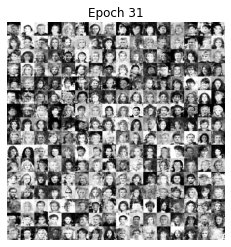

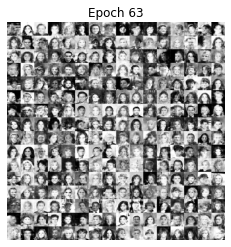

In [ ]:
WTrain = (
    WDTrain_GP,
    WDTrain_GP,
    WDTrain_GP,
    WDTrain_GP,
    WDTrain_GP,
    WGTrain_GP
)

WCritic = len(WTrain)

wlg = [None] * W_EPOCH #record loss of g for each epoch
wld = [None] * W_EPOCH #record loss of d for each epoch
wsp = [None] * W_EPOCH #record sample images for each epoch

rsTrain = float(BATCH_SIZE) / float(len(data_path))
ctr = 0
for ep in range(W_EPOCH):
    lgt = 0.0
    ldt = 0.0
    for c1 in dsTrain:
        lg, ld = WTrain[ctr](c1)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == WCritic : ctr = 0
    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    
    out = WG(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "./w_%04d.png" % ep
    )
    wsp[ep] = img
    if (ep+1) % 32 == 0:
        
        plt.imshow(img[..., 0], cmap = "gray")
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

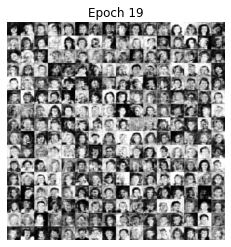

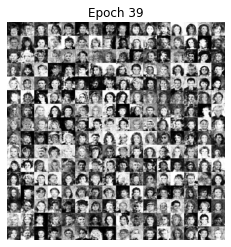

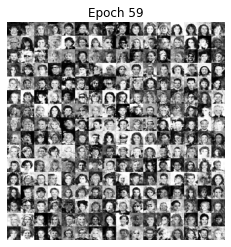

KeyboardInterrupt: 

In [10]:
WTrain = (
    WDTrain_GP,
    WDTrain_GP,
    WDTrain_GP,
    WDTrain_GP,
    WDTrain_GP,
    WGTrain_GP
)

WCritic = len(WTrain)

wlg = [None] * W_EPOCH #record loss of g for each epoch
wld = [None] * W_EPOCH #record loss of d for each epoch
wsp = [None] * W_EPOCH #record sample images for each epoch

rsTrain = float(BATCH_SIZE) / float(len(data_path))
ctr = 0
for ep in range(W_EPOCH):
    lgt = 0.0
    ldt = 0.0
    for c1 in dsTrain:
        lg, ld = WTrain[ctr](c1)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == WCritic : ctr = 0
    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    
    out = WG(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "./w_%04d.png" % ep
    )
    wsp[ep] = img
    if (ep+1) % 20 == 0:
        
        plt.imshow(img[..., 0], cmap = "gray")
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

#### 因時間關係，只train到了70幾個epoch

In [12]:
utMakeGif(np.array(wsp[:70]), "./wgan.gif", duration = 2)

t:   0%|                                                                              | 0/70 [00:00<?, ?it/s, now=None]

MoviePy - Building file ./wgan.gif with imageio.



t:  96%|██████████████████████████████████████████████████████████████████   | 67/70 [00:48<00:02,  1.36it/s, now=None]


t: 100%|█████████████████████████████████████████████████████████████████████| 70/70 [00:50<00:00,  1.41it/s, now=None]
                                                                                                                       

## Loss Curve

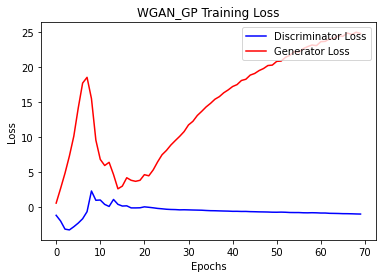

In [14]:
plt.plot(range(70), wld[:70], color = "blue", label = "Discriminator Loss")
plt.plot(range(70), wlg[:70], color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN_GP Training Loss")
plt.show()

## Summary
#### 1.先對資料作前處理
#### 2.在對原本的WGAN做修改，加入penalty
#### 3.取部分訓練過程用gif檔紀錄
#### 4.最後畫Training Loss Curve